# Define & solve ODE

In [1]:
using Damysos
using StaticArrays

In [201]:
print(Damysos.printparamsSI(sim))

ζ = 3.57
γ = 1.4
M = 5.0
plz = 1.68e-5
BZ(kx) = [-0.0332 Å^-1,0.0332 Å^-1] ([-85.4,85.4])
BZ(ky) = [-0.00389 Å^-1,0.00389 Å^-1] ([-10.0,10.0])
m  = 20.0 meV (15.707963267948971)
vF = 497000.0 m s^-1 (1.0)t1 = Inf fs (Inf)
t2 = Inf fs (Inf)
σ = 517.0 fs (1.0)
ω = 0.0122 fs^-1 (6.28)
ν = 1.93 THz (1.0)
eE = 0.00349 MV cm^-1 (70.5)
φ = 0.0 (0.0)
ħω = 0.008 eV (6.28)
kxmax = 0.0389 Å^-1 (100.0)
dkx = 0.000389 Å^-1 (1.0)
nkx = 200.0 (200.0)
kymax = 0.00389 Å^-1 (10.0)
dky = 0.000778 Å^-1 (2.0)
nky = 10.0 (10.0)
t0 = -5170.0 fs (-10.0)
dt = 5.17 fs (0.01)
rtol = 1.0e-12 (1.0e-12)
atol = 1.0e-12 (1.0e-12)
nt = 2000.0 (2000.0)


In [160]:
vf = u"497070.0m/s"
m = u"0.02eV"
# freq      = u"25.0THz"
# emax      = u"0.5MV/cm"
e = uconvert(u"C", 1u"eV" / 1u"V")

M = 5.0
γ = 0.7
ζ = M / γ


ω = 2m / (M * Unitful.ħ)
freq = uconvert(u"THz", ω / 2π)
σ = uconvert(u"fs", 1 / freq)
emax = uconvert(u"MV/cm", ω * m / (2vf * e * γ))
us = scaledriving_frequency(freq, vf)

tcyc = timescaled(1 / freq,us)
t2 = Inf 
t1 = Inf


df = GaussianAPulse(us, σ, freq, emax)
h = GappedDirac(us, m, vf)
l = TwoBandDephasingLiouvillian(h, t1, t2)
pars    = NumericalParams2d(1.0,2.0,100.0,10.0,0.01,-10df.σ)
obs     = [Velocity(h)]
id      = "M=$(M)_gamma=$γ"
dpath   = "results"
ppath   = dpath
sim = Simulation(l,df,pars,obs,us,2,id,dpath,ppath)

Simulation{Float64} (2d):
 TwoBandDephasingLiouvillian(GappedDirac)
   Hamiltonian: GappedDirac
   m: 15.707963267948971
   vF: 1.0
  t1: Inf
  t2: Inf
 GaussianAPulse:
  σ: 1.0
  ν: 1.0000000000000002
  ω: 6.283185307179587
  eE: 70.49717429349543
  φ: 0.0
  ħω: 6.283185307179587
 NumericalParams2d:
  dkx: 1.0
  dky: 2.0
  kxmax: 100.0
  kymax: 10.0
  dt: 0.01
  t0: -10.0
  rtol: 1.0e-12
  atol: 1.0e-12
  nkx: 200
  nky: 10
  nt: 2001
  tsamples: -10.0:0.01:10.0
  tspan: (-10.0, 10.0)
  kxsamples: LinRange{Float64}(-100.0, 100.0, 200)
  kysamples: LinRange{Float64}(-10.0, 10.0, 10)
 Observables:
  Velocity
 UnitScaling:
  timescale: 516.9584621154825 fs
  lengthscale: 256.9645427637428 nm
 id: "M=5.0_gamma=0.7"
 datapath: "results"
 plotpath: "results"


In [235]:
rhs = define_rhs_x(sim)
tspan = gettspan(sim.numericalparams)
u0   = SA[0.0im,0.0im] # (ρcc,ρcv)
p    = SA[0.0,0.0] #(kx,ky)
prob = ODEProblem(rhs,u0,tspan,p)
ts   = range(tspan[1],tspan[2],10_000)
sol  = solve(prob,abstol=1e-12,reltol=1e-7,saveat=ts);

# Plot occupation

In [236]:
using CairoMakie

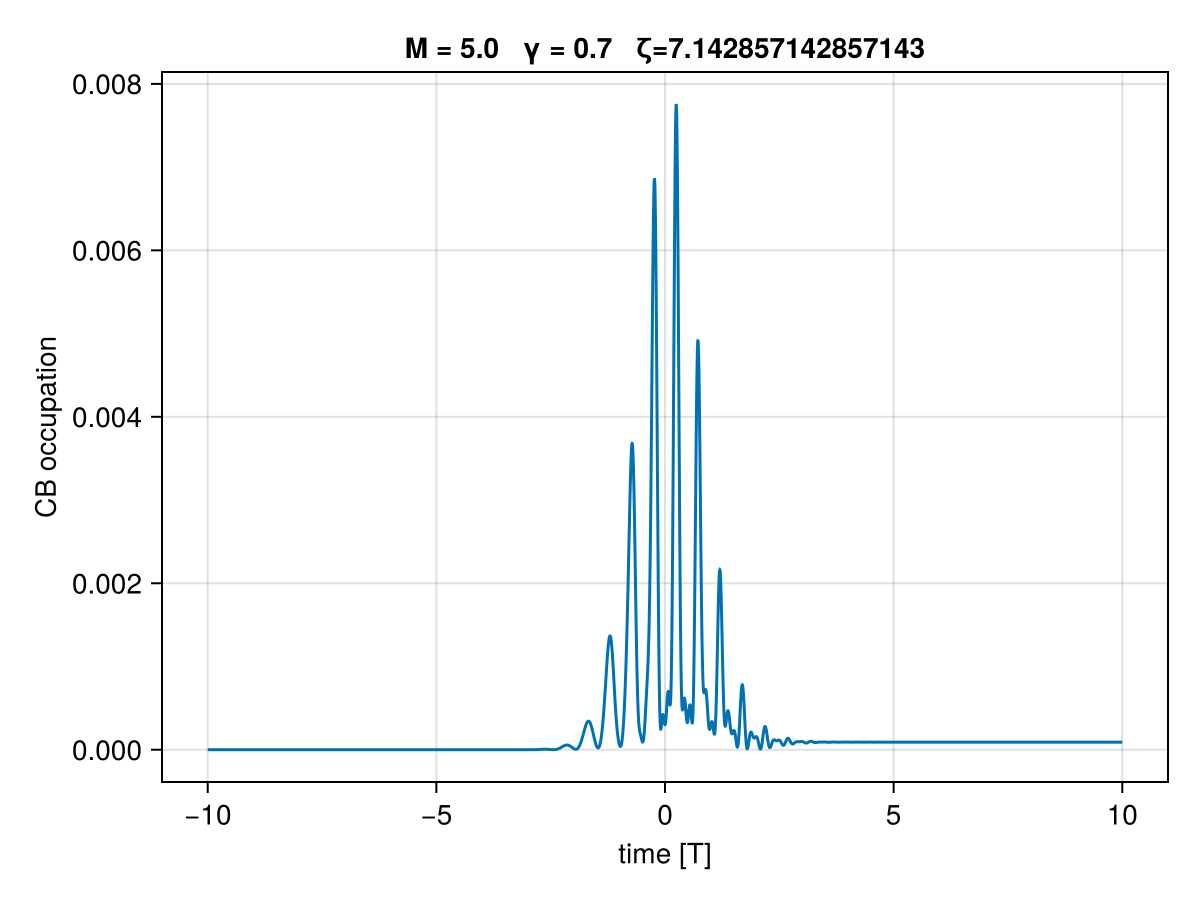

In [237]:
occs = real.(sol[1,:])
lines(sol.t,occs;
    axis = (; title = "M = $M   γ = $γ   ζ=$ζ", xlabel = "time [T]", ylabel = "CB occupation"))

# Plot velocities

In [238]:
v_expr = Damysos.buildobservable_expression_upt(sim,Velocity(pars))
p = SA[0.,0.]
@eval v(u,p,t) = $v_expr
vxinter(u,p,t) = v(u,p,t)[2]
vxintra(u,p,t) = v(u,p,t)[1]

vxintra (generic function with 1 method)

In [239]:
vxra = [vxintra(u,p,t) for (u,t) in zip(sol.u,sol.t)]
vxer = [vxinter(u,p,t) for (u,t) in zip(sol.u,sol.t)]
vx   = vxra .+ vxer
data = hcat(vxra,vxer,vx);

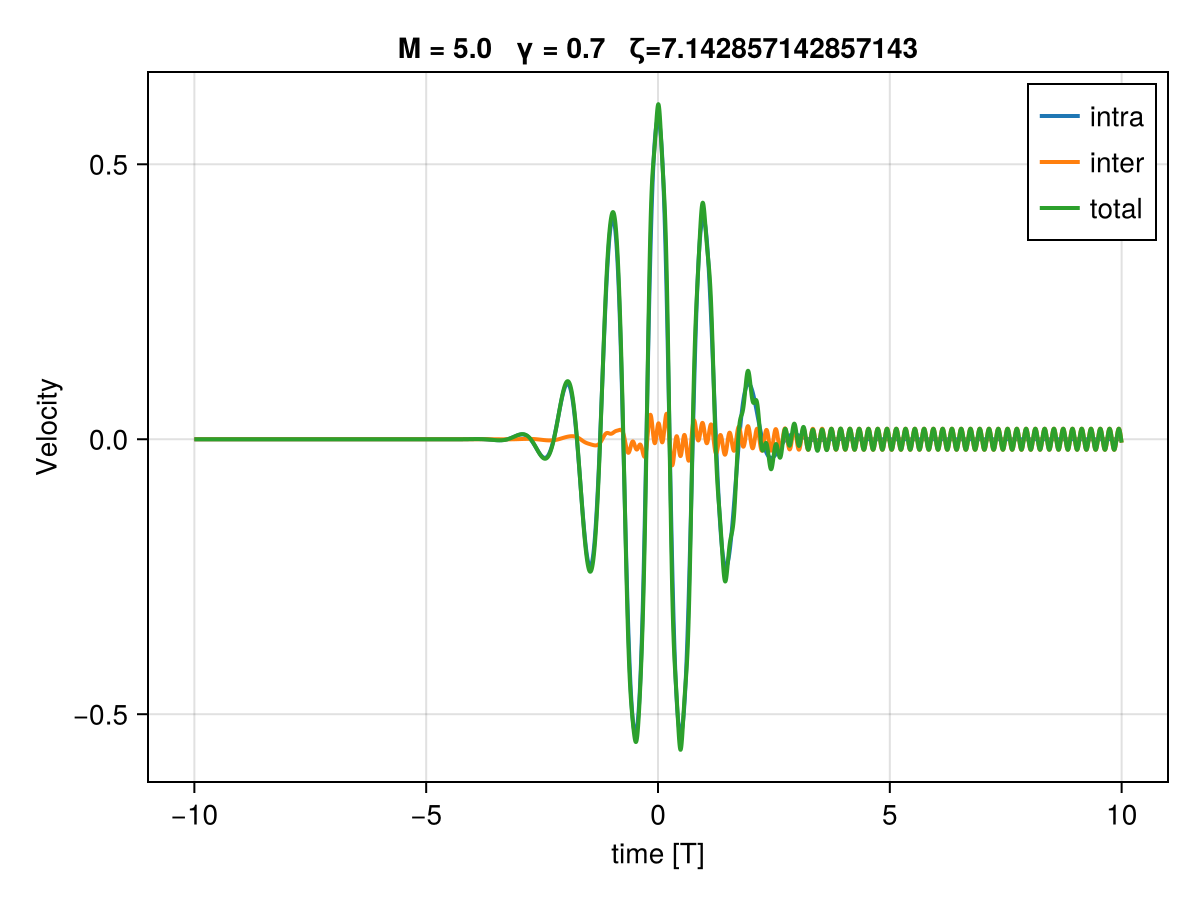

In [240]:
fig,ax = series(sol.t,data';
    axis = (; title = "M = $M   γ = $γ   ζ=$ζ", xlabel = "time [T]", ylabel = "Velocity"),
    labels = ["intra","inter", "total"],
    color = :tab10)
axislegend(ax)
fig

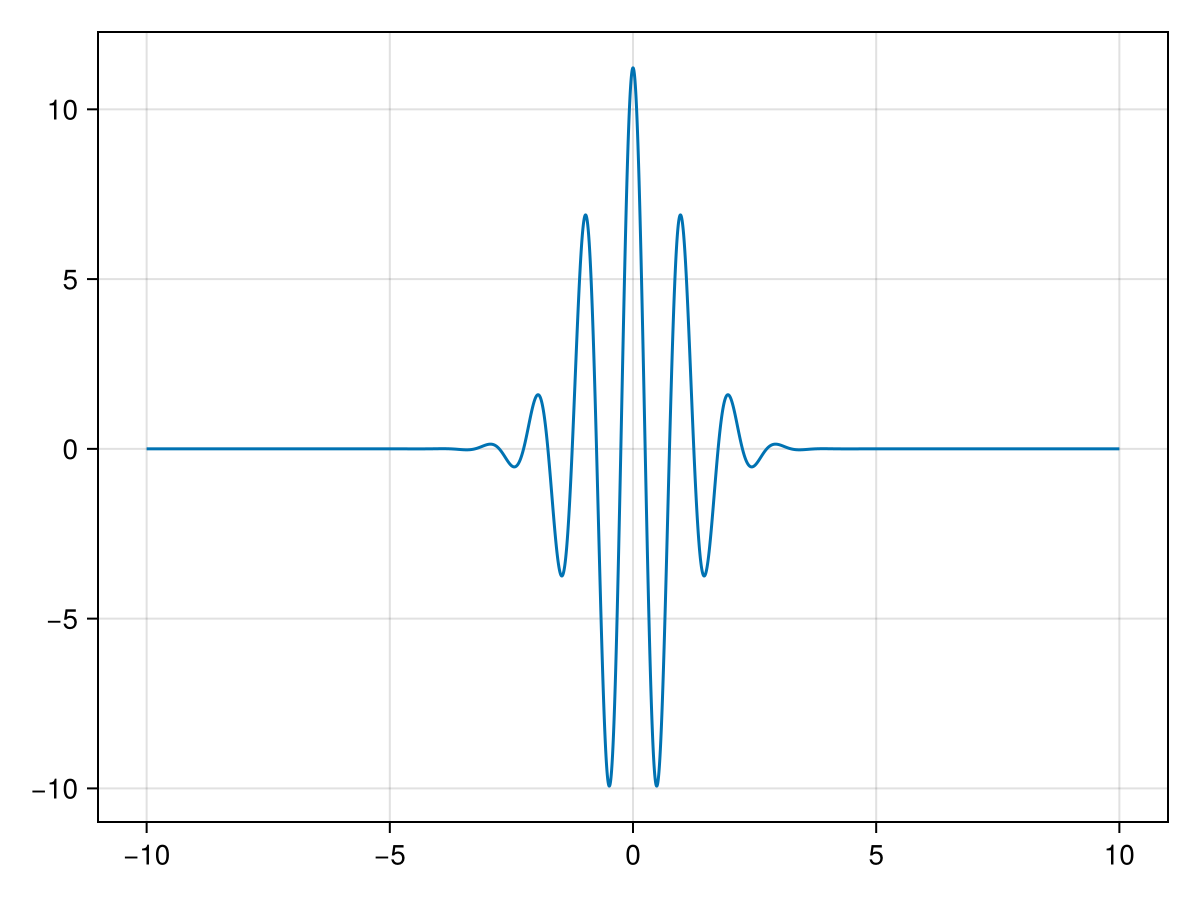

In [241]:
inds = 1:600
ax = t -> vecpotx(df,t)
lines(sol.t,ax.(sol.t))

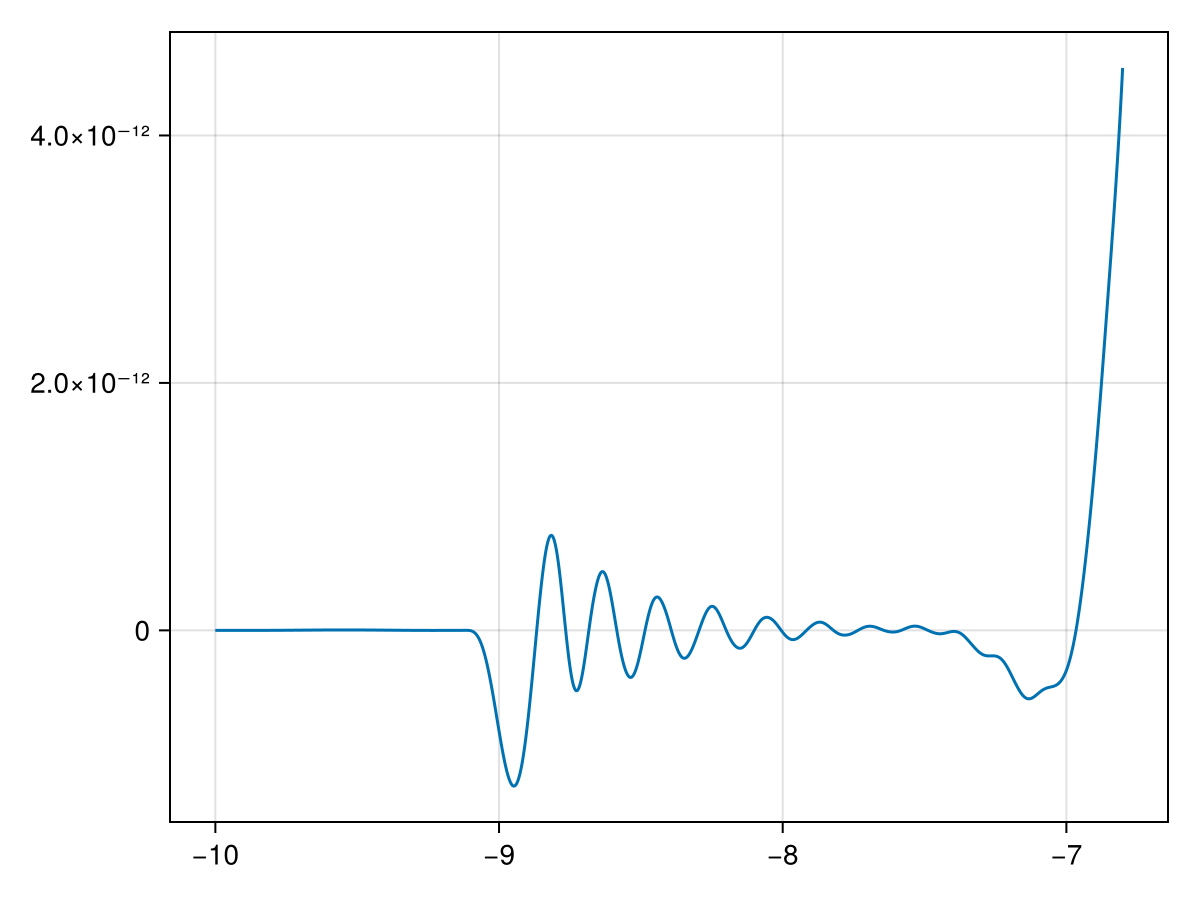

In [242]:
inds = 1:1600
lines(sol.t[inds],vxer[inds])

# Plot spectra

In [243]:
using DSP
using FFTW
function applyhanning(x::Vector) 
    if iseven(length(x))
        pushfirst!(x,x[1])
    end
    return x .* hanning(length(x))
end
pad(x::Vector,n::Integer) = vcat(x,zeros(eltype(x),n))

pad (generic function with 1 method)

In [244]:
dt = sum(diff(sol.t)) / (length(sol.t)-1)
fs = 1/dt
fre = rfftfreq(length(sol.t),fs);

In [245]:
length(fre)

5001

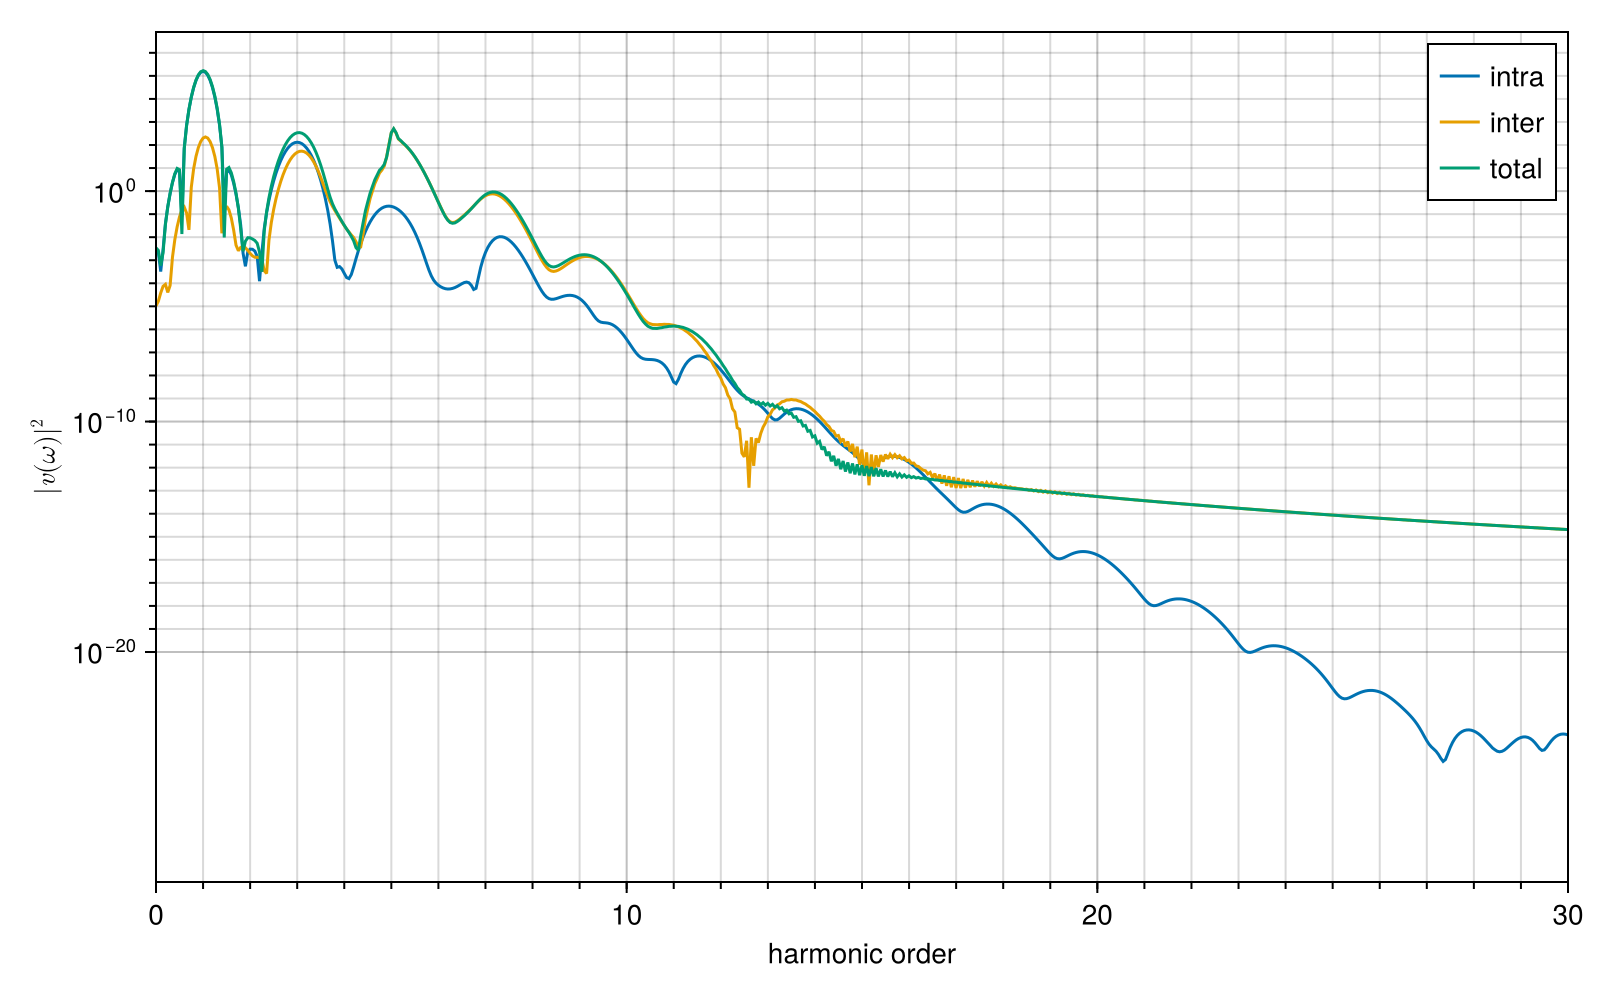

In [246]:
f   = Figure(size=(800,500))
vxrafft = abs2.(rfft(applyhanning(vxra)))
vxerfft = abs2.(rfft(applyhanning(vxer)))
vxfft   = abs2.(rfft(applyhanning(vxra .+ vxer)))
ax  = Axis(f[1,1],yscale=log10,xlabel="harmonic order",ylabel=L"|v(ω)|^2",
    xminorticksvisible=true,
    xminorgridvisible=true,
    xminorgridcolor=RGBAf(0,0,0,0.15),
    yminorgridcolor=RGBAf(0,0,0,0.15),
    xminorticks=0:100,
    yminorticksvisible=true,
    yminorgridvisible=true,
    yminorticks=[10.0^j for j in -20:10])
lines!(ax,fre,vxrafft,label="intra")
lines!(ax,fre,vxerfft,label="inter")
lines!(ax,fre,vxfft,label="total")
axislegend(ax)
xlims!(ax,0,30)
f